Data Set Information:

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

Attribute Information:

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

## 1. Import libraries and dataset

In [3]:
library(lubridate) ## Parse Dates
library(caTools)   ## split dataset into train and test sets
library(caret)     ## K cross validation
library(gam)       


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress


Loading required package: splines

Loading required package: foreach

Loaded gam 1.20




In [13]:
bike_share <- read.csv("../input/bike-sharing-dataset/hour.csv", header=T)

In [15]:
bike_share <- bike_share[,-c(1,2,12,15,16)]

In [16]:
head(bike_share)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
1,1,0,1,0,0,6,0,1,0.24,0.81,0.0000,16
2,1,0,1,1,0,6,0,1,0.22,0.80,0.0000,40
3,1,0,1,2,0,6,0,1,0.22,0.80,0.0000,32
4,1,0,1,3,0,6,0,1,0.24,0.75,0.0000,13
5,1,0,1,4,0,6,0,1,0.24,0.75,0.0000,1
6,1,0,1,5,0,6,0,2,0.24,0.75,0.0896,1


We can ignore column id, casual and registered users

In [18]:
str(bike_share)

'data.frame':	17379 obs. of  12 variables:
 $ season    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ yr        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ mnth      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ hr        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ holiday   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ weekday   : int  6 6 6 6 6 6 6 6 6 6 ...
 $ workingday: int  0 0 0 0 0 0 0 0 0 0 ...
 $ weathersit: int  1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  0.24 0.22 0.22 0.24 0.24 0.24 0.22 0.2 0.24 0.32 ...
 $ hum       : num  0.81 0.8 0.8 0.75 0.75 0.75 0.8 0.86 0.75 0.76 ...
 $ windspeed : num  0 0 0 0 0 0.0896 0 0 0 0 ...
 $ cnt       : int  16 40 32 13 1 1 2 3 8 14 ...


In [19]:
attach(bike_share)

The following objects are masked from bike_share (pos = 3):

    cnt, holiday, hr, hum, mnth, temp, weathersit, weekday, windspeed,
    workingday, yr




In [20]:
bike_share$season <- as.factor(season)
bike_share$holiday <- as.factor(holiday)
bike_share$workingday <- as.factor(workingday)
bike_share$weathersit <- as.factor(weathersit)

bike_share$yr <- as.factor(yr) ## 
bike_share$weekday <- as.factor(weekday)
bike_share$hr <- as.factor(hr)
bike_share$mnth <- as.factor(mnth)

In [21]:
str(bike_share)

'data.frame':	17379 obs. of  12 variables:
 $ season    : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ yr        : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ mnth      : Factor w/ 12 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ hr        : Factor w/ 24 levels "0","1","2","3",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ holiday   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ weekday   : Factor w/ 7 levels "0","1","2","3",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ workingday: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ weathersit: Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  0.24 0.22 0.22 0.24 0.24 0.24 0.22 0.2 0.24 0.32 ...
 $ hum       : num  0.81 0.8 0.8 0.75 0.75 0.75 0.8 0.86 0.75 0.76 ...
 $ windspeed : num  0 0 0 0 0 0.0896 0 0 0 0 ...
 $ cnt       : int  16 40 32 13 1 1 2 3 8 14 ...


In [22]:
cor(bike_share[,9:12])

,temp,hum,windspeed,cnt
temp,1.00000000,-0.06988139,-0.02312526,0.40477228
hum,-0.06988139,1.00000000,-0.29010490,-0.32291074
windspeed,-0.02312526,-0.29010490,1.00000000,0.09323378
cnt,0.40477228,-0.32291074,0.09323378,1.00000000


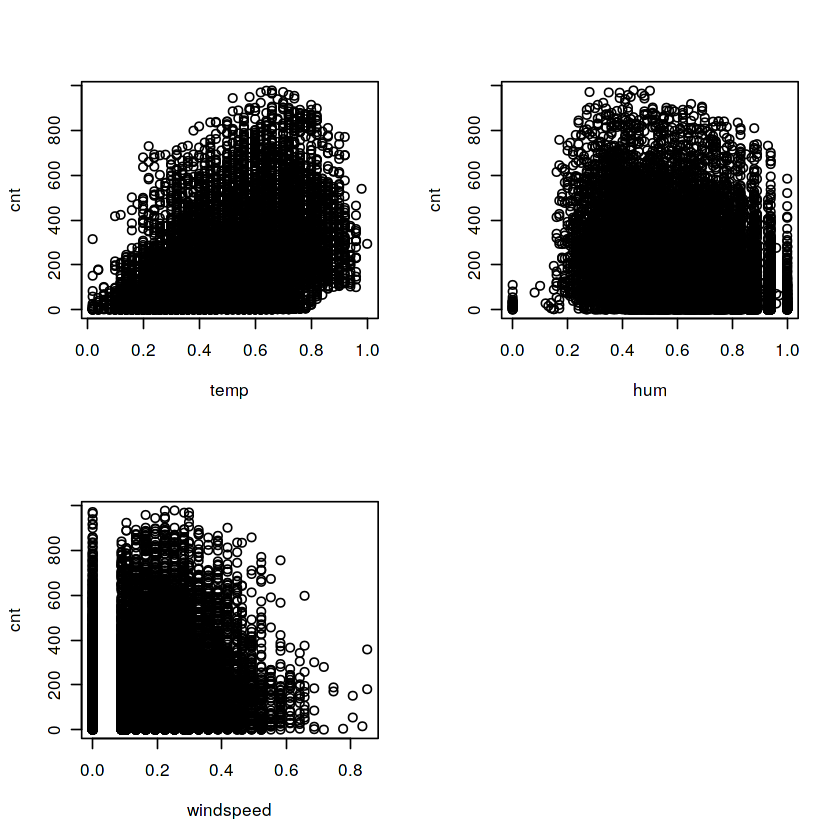

In [24]:
par(mfrow=c(2,2))
plot(temp,cnt)
plot(hum,cnt)
plot(windspeed,cnt)

## 2. Split dataset into training and test set

In [25]:
set.seed(123)
split <- sample.split(bike_share$cnt, SplitRatio = 0.80)
train_set <- subset(bike_share, split == TRUE)
test_set <- subset(bike_share, split == FALSE)

## 3. Linear model

In [26]:
lm1 <- lm(cnt~.-workingday, data = train_set)
summary(lm1)


Call:
lm(formula = cnt ~ . - workingday, data = train_set)

Residuals:
    Min      1Q  Median      3Q     Max 
-388.94  -61.20   -7.31   51.63  432.91 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -81.936      7.392 -11.084  < 2e-16 ***
season2       38.260      5.472   6.992 2.83e-12 ***
season3       33.955      6.478   5.242 1.62e-07 ***
season4       66.274      5.498  12.054  < 2e-16 ***
yr1           86.631      1.763  49.135  < 2e-16 ***
mnth2          4.165      4.442   0.937 0.348525    
mnth3         17.261      4.979   3.467 0.000529 ***
mnth4         10.804      7.384   1.463 0.143449    
mnth5         22.056      7.905   2.790 0.005278 ** 
mnth6          6.199      8.121   0.763 0.445295    
mnth7        -14.542      9.086  -1.600 0.109513    
mnth8          6.506      8.834   0.736 0.461480    
mnth9         32.592      7.858   4.147 3.38e-05 ***
mnth10        21.710      7.293   2.977 0.002916 ** 
mnth11        -3.320      7.030  -0.

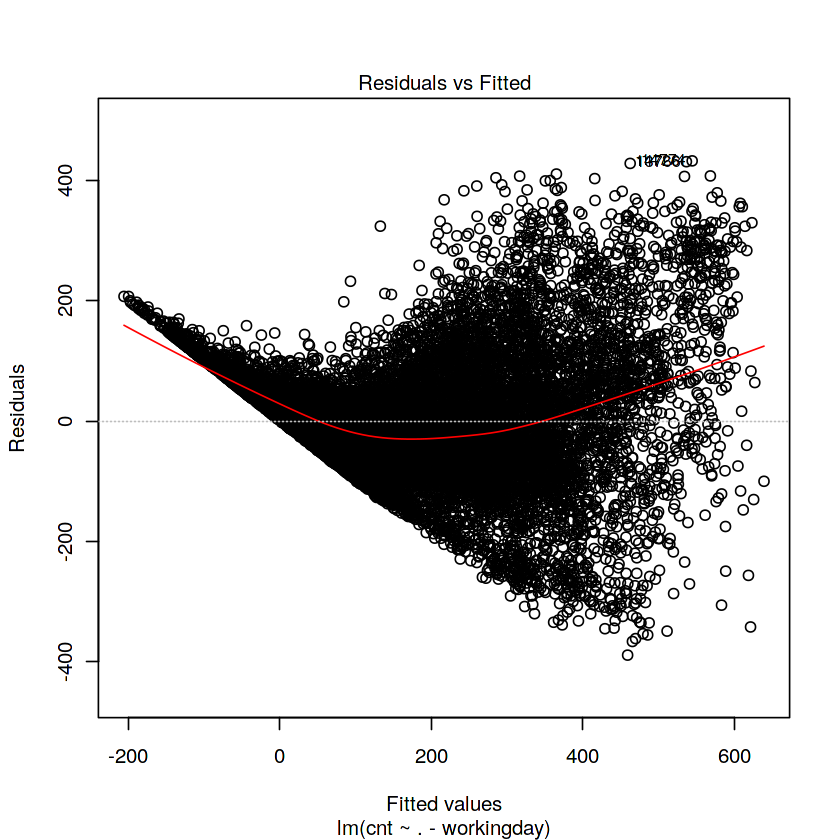

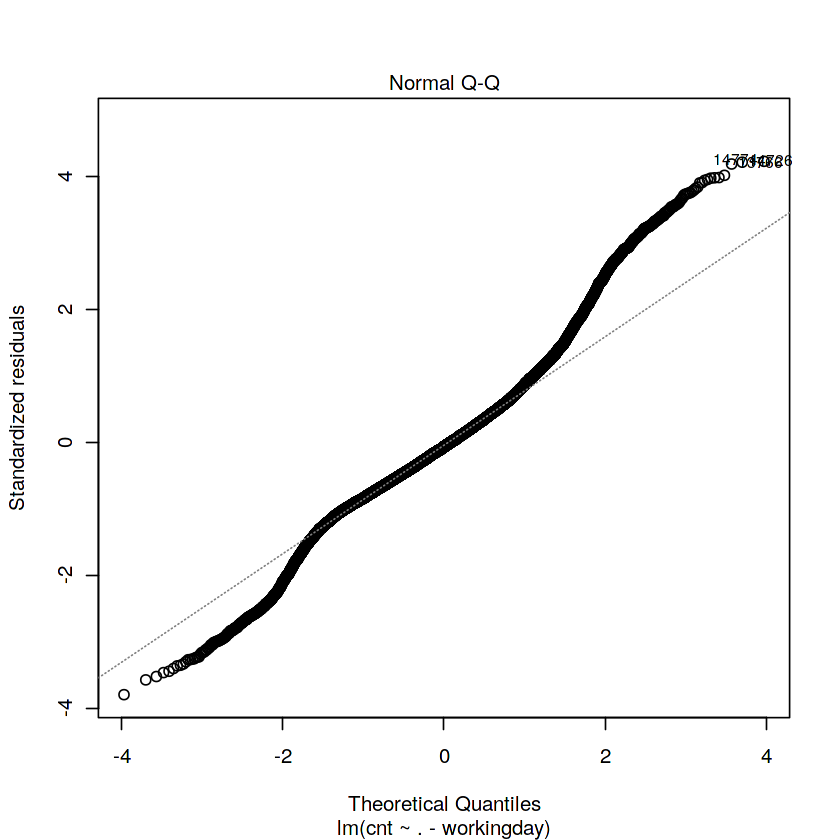

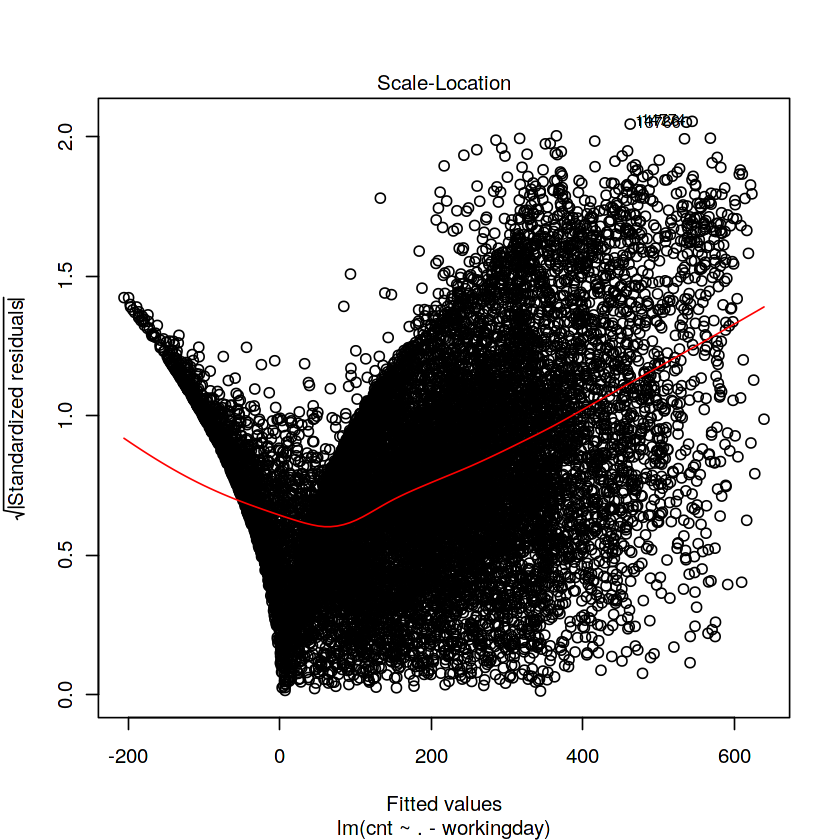

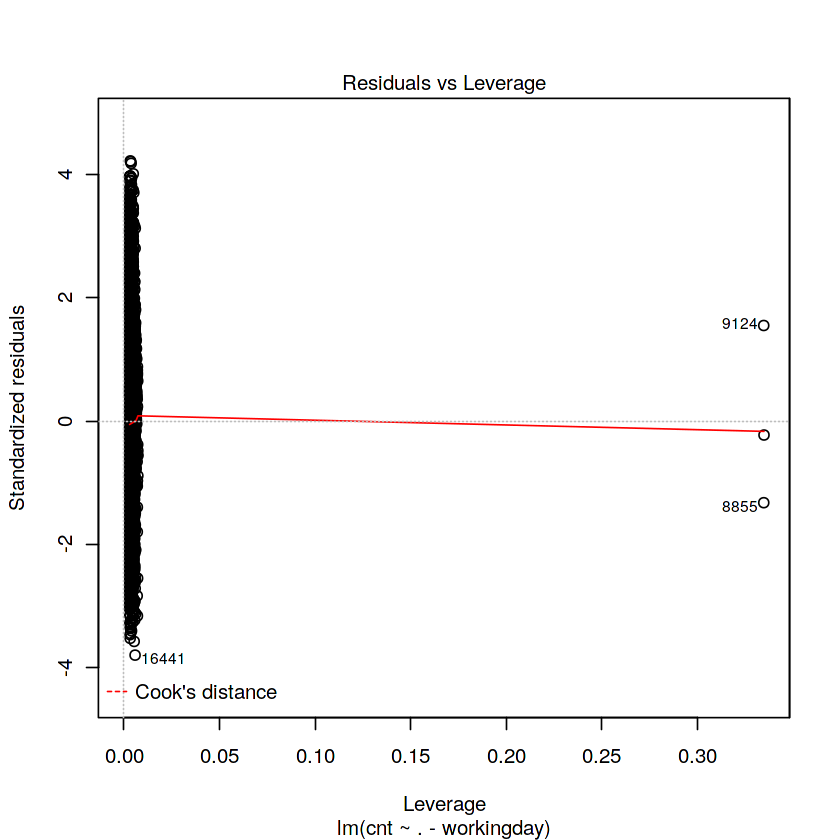

In [29]:
par(mfrow=c(1,1))
plot(lm1)

In [85]:
pred.lm1 = predict(lm1,newdata=test_set)

In [86]:
postResample(pred.lm1,test_set$cnt)

RMSE  Rsquared       MAE 
98.123266  0.677115 73.145847

## GAM

In [33]:
gam1 <- gam(cnt~s(temp)+s(hum)+s(windspeed)+season+yr+mnth+hr+holiday+weekday+weathersit, data = train_set)

In [34]:
summary(gam1)


Call: gam(formula = cnt ~ s(temp) + s(hum) + s(windspeed) + season + 
    yr + mnth + hr + holiday + weekday + weathersit, data = train_set)
Deviance Residuals:
     Min       1Q   Median       3Q      Max 
-379.494  -61.087   -6.777   52.444  430.198 

(Dispersion Parameter for gaussian family taken to be 10298.67)

    Null Deviance: 469639752 on 13931 degrees of freedom
Residual Deviance: 142852796 on 13871 degrees of freedom
AIC: 168328.6 

Number of Local Scoring Iterations: NA 

Anova for Parametric Effects
                Df    Sum Sq  Mean Sq   F value    Pr(>F)    
s(temp)          1  74153880 74153880 7200.3385 < 2.2e-16 ***
s(hum)           1  42050141 42050141 4083.0668 < 2.2e-16 ***
s(windspeed)     1    201950   201950   19.6093 9.573e-06 ***
season           3  17799277  5933092  576.1030 < 2.2e-16 ***
yr               1  21938572 21938572 2130.2344 < 2.2e-16 ***
mnth            11   7679525   698139   67.7892 < 2.2e-16 ***
hr              23 160149991  6963043  676.111

In [32]:
coef(gam1)

(Intercept)      s(temp)       s(hum) s(windspeed)      season2      season3 
-98.26869096 258.65591202 -83.64039138 -39.46729802  37.99772025  33.90625841 
     season4          yr1        mnth2        mnth3        mnth4        mnth5 
 68.63293300  87.49343944  14.23652815  28.63485644  21.05632601  20.63030647 
       mnth6        mnth7        mnth8        mnth9       mnth10       mnth11 
  0.08274762 -18.97520707  -2.21855819  27.27783134  27.08395177   7.16991799 
      mnth12          hr1          hr2          hr3          hr4          hr5 
  7.65331079 -18.86199557 -27.31249721 -37.83298567 -41.57942803 -22.40255411 
         hr6          hr7          hr8          hr9         hr10         hr11 
 35.54240986 172.41908744 313.24422961 160.05749562 104.65046438 135.54511371 
        hr12         hr13         hr14         hr15         hr16         hr17 
171.79724538 168.43188594 151.11378569 160.41694966 225.28562827 384.35293530 
        hr18         hr19         hr20         hr21         hr22         hr23 
350.46833408 234.84334828 155.84662011 108.17086781  70.41095045  30.40945241 
    holiday1     weekday1     weekday2     weekday3     weekday4     weekday5 
-31.72049793  10.34700154  13.50235991  14.91593588  14.91059911  19.47339142 
    weekday6  weathersit2  weathersit3  weathersit4 
 18.21312475 -10.86725091 -60.86576478 -65.50164630

The summary is splitted into two parts: Anova for Parametric Effects and Anova for Non parametric effects. 
The variables modeled with a smoothing spline are all significant in both parts. The other variables are not modeled with a smoothing spline because they are categorical variables, so they don't have any nonparametric effect. It's satisfactory as significance. 

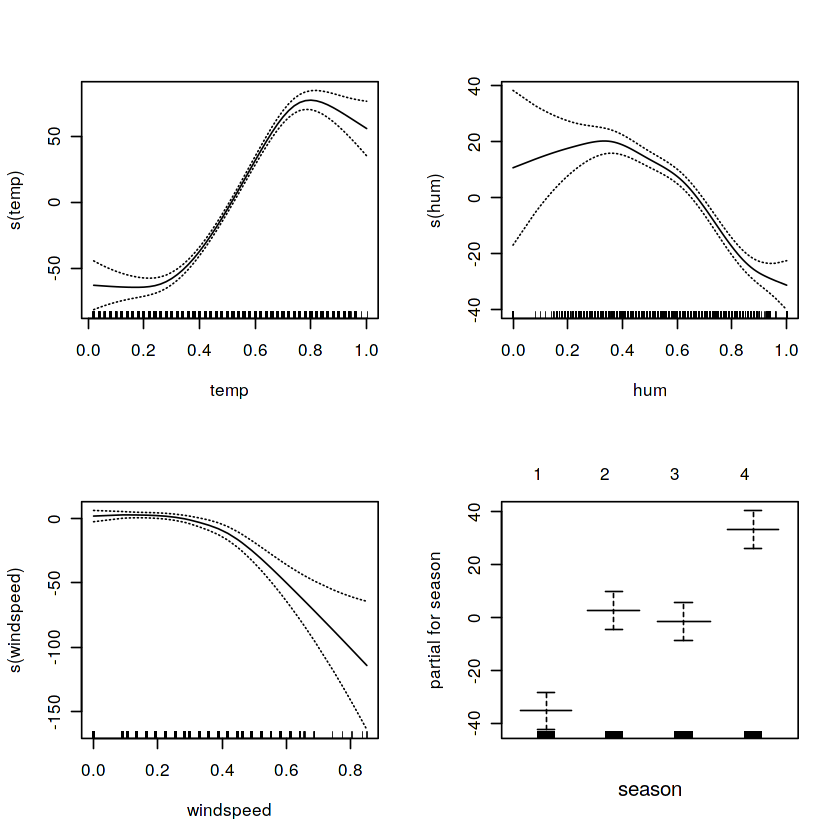

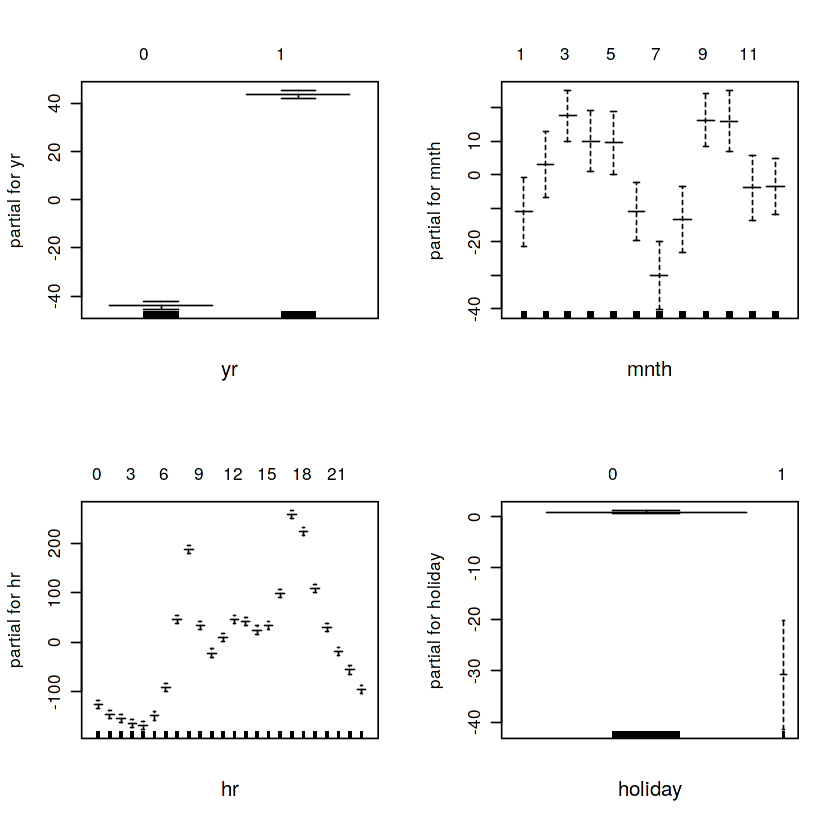

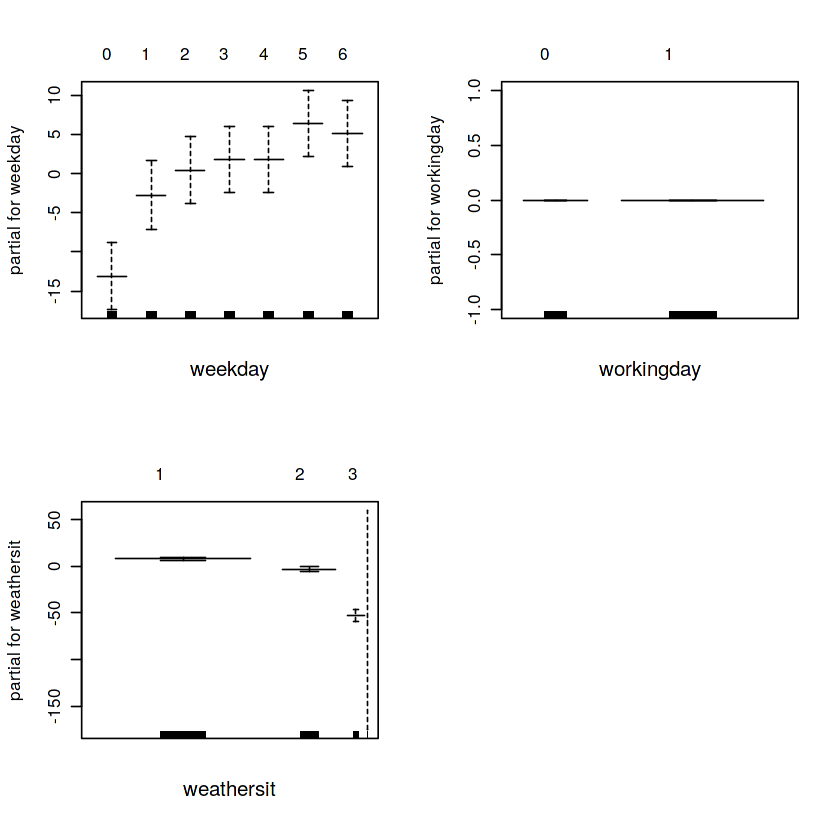

In [102]:
par(mfrow=c(2,2))
plot(gam1, se=T)

We can observe that both temp, hum, windspeed are characterized by a non linear relationship with respect to the response variable. To see if the gam model is better than the linear model, we can look the AIC to confront them. 

In [70]:
AIC(gam1)

[1] 168328.6

In [71]:
AIC(lm1)

[1] 168646

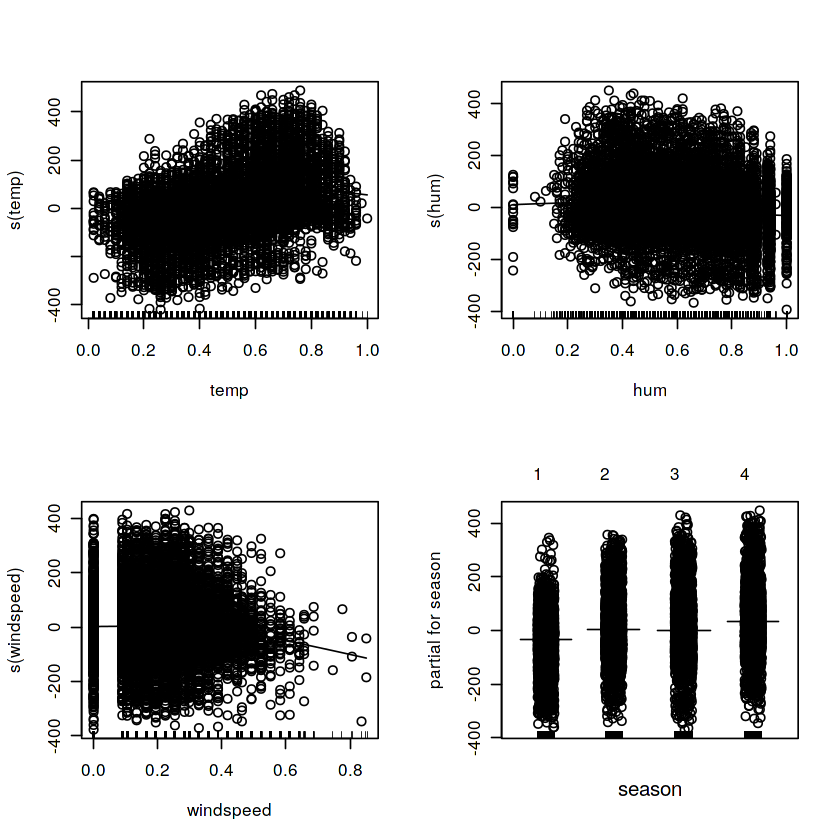

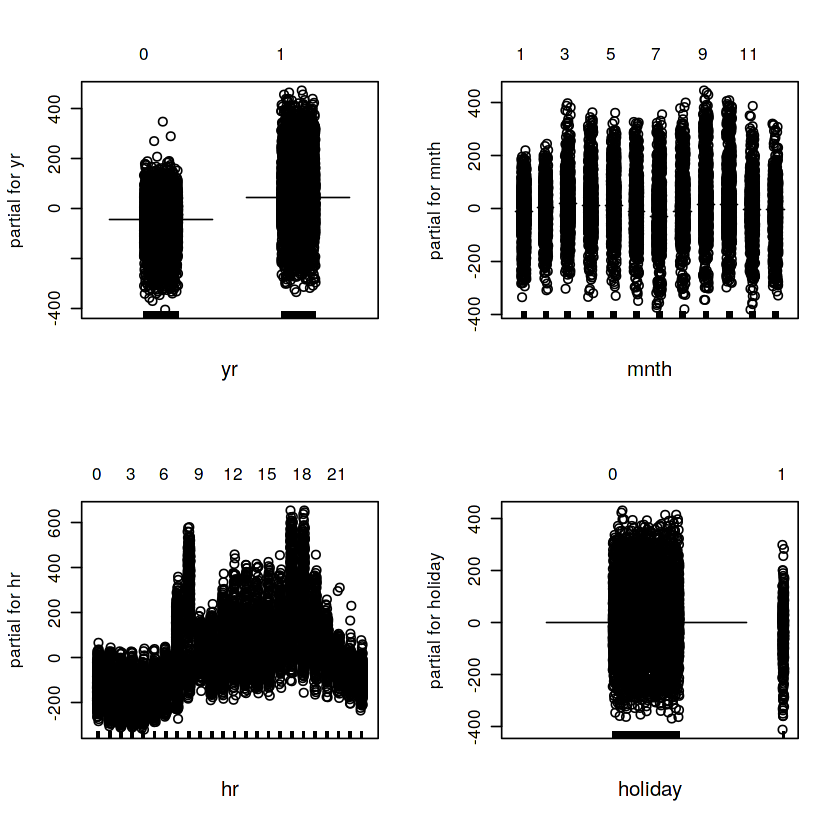

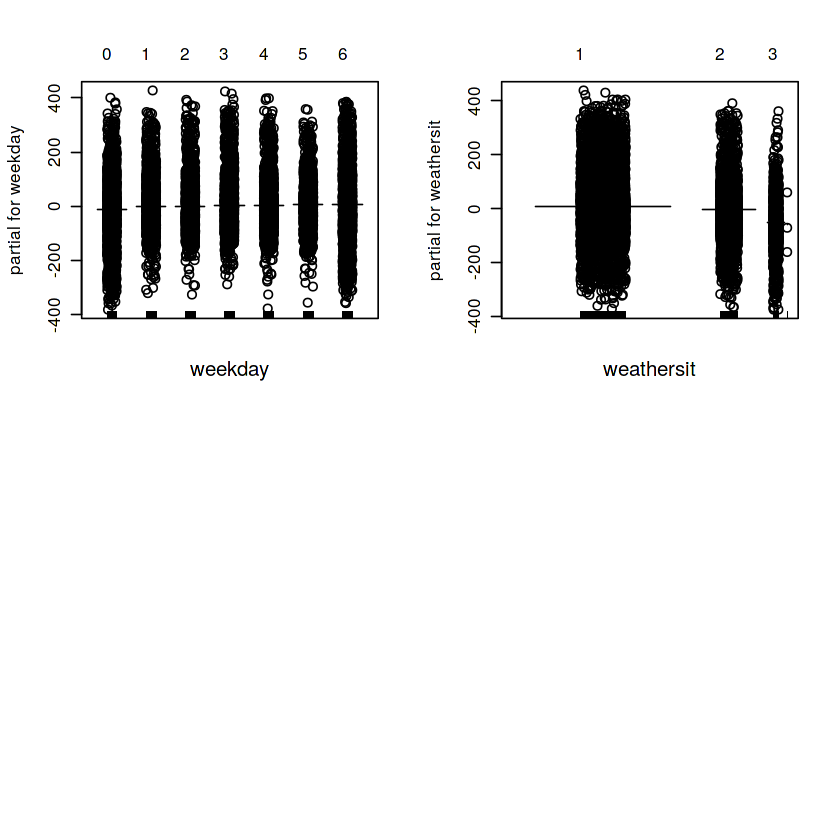

In [40]:
par(mfrow=c(2,2))
plot(gam1,residuals=T,pch = 1)

THe AIC of gam model is smaller than the one of the multiple linear regression model, so the GAM model is technically better than the linear model. It's an indication that we are satisfied more with the GAM model. 

In [91]:
p.gam1 <- predict(gam1, newdata=test_set)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


In [92]:
postResample(p.gam1,test_set$cnt)

RMSE   Rsquared        MAE 
97.1740025  0.6830996 72.6659860

In [74]:
gam2<- gam(cnt~lo(temp)+lo(hum)+lo(windspeed)+season+yr+mnth+hr+holiday+weekday+workingday+weathersit,data=train_set)

In [75]:
summary(gam2)


Call: gam(formula = cnt ~ lo(temp) + lo(hum) + lo(windspeed) + season + 
    yr + mnth + hr + holiday + weekday + workingday + weathersit, 
    data = train_set)
Deviance Residuals:
     Min       1Q   Median       3Q      Max 
-380.446  -61.335   -6.842   52.474  430.553 

(Dispersion Parameter for gaussian family taken to be 10326.63)

    Null Deviance: 469639752 on 13931 degrees of freedom
Residual Deviance: 143254569 on 13872.34 degrees of freedom
AIC: 168365.1 

Number of Local Scoring Iterations: NA 

Anova for Parametric Effects
                 Df    Sum Sq  Mean Sq   F value    Pr(>F)    
lo(temp)          1  74074172 74074172 7173.1181 < 2.2e-16 ***
lo(hum)           1  41595267 41595267 4027.9595 < 2.2e-16 ***
lo(windspeed)     1    200098   200098   19.3769 1.081e-05 ***
season            3  17225471  5741824  556.0208 < 2.2e-16 ***
yr                1  21728975 21728975 2104.1681 < 2.2e-16 ***
mnth             11   7643255   694841   67.2863 < 2.2e-16 ***
hr             

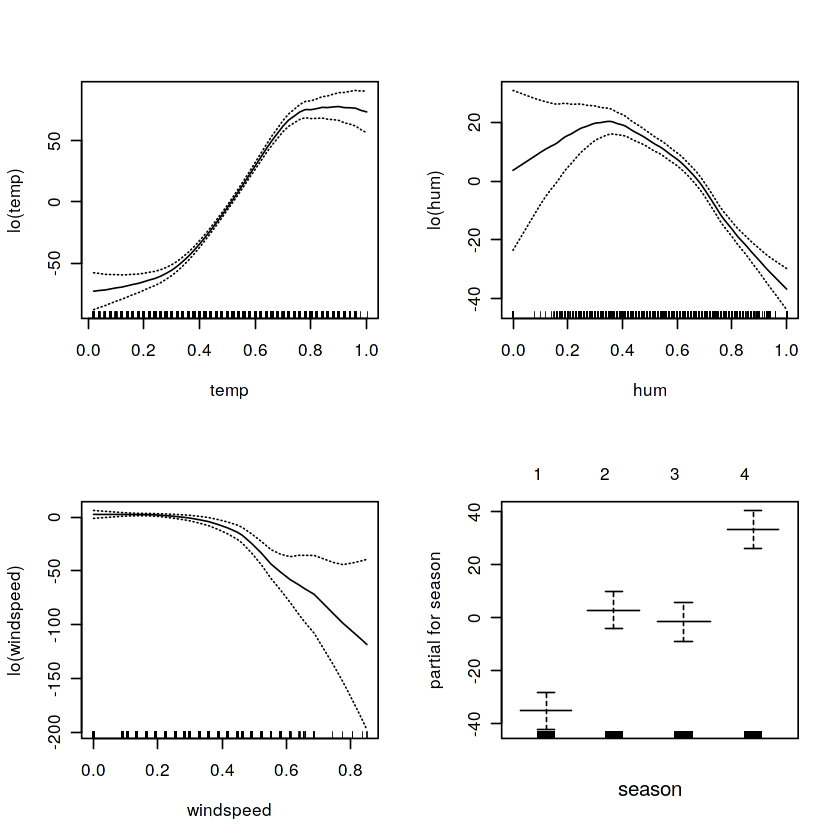

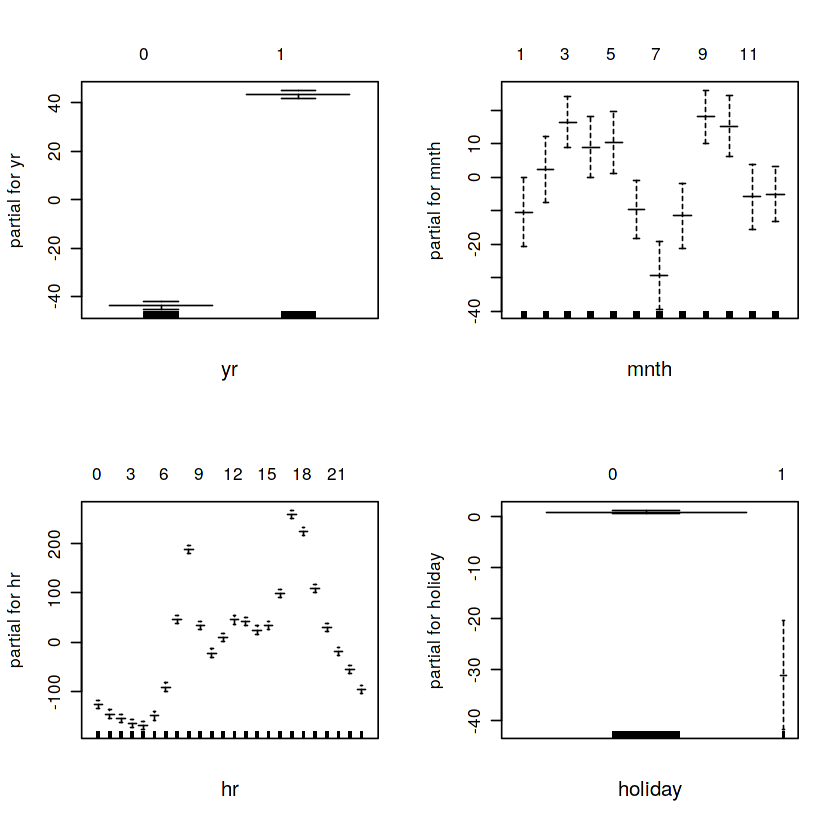

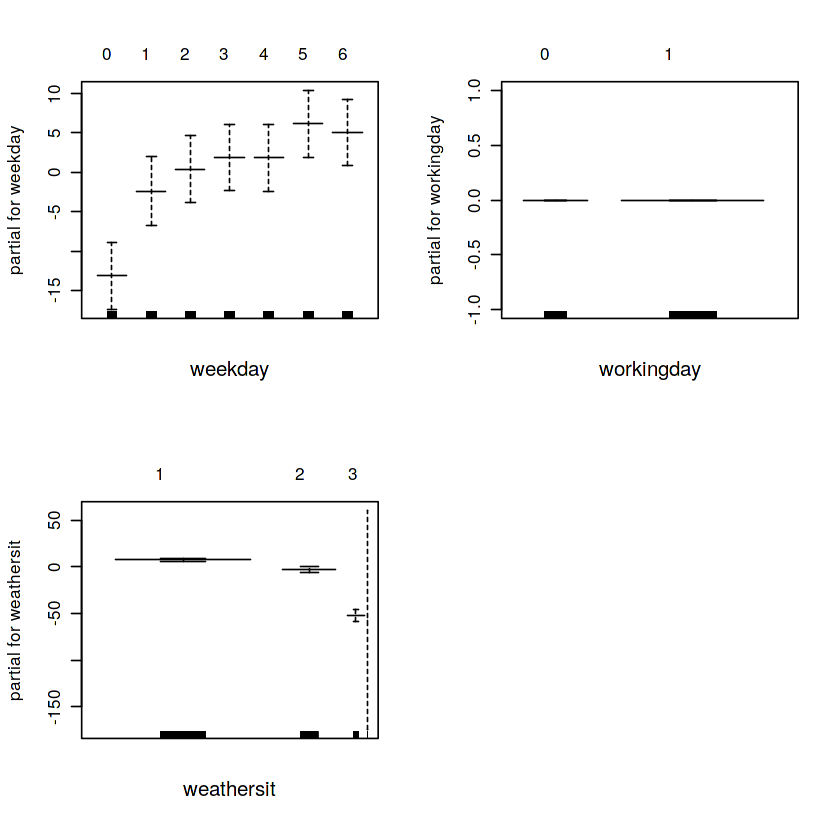

In [76]:
par(mfrow=c(2,2))
plot(gam2, se=T)

In [79]:
AIC(gam1)
AIC(lm1)

[1] 168328.6

In [78]:
AIC(gam2)

[1] 168365.1

In [93]:
pred.gam2 <- predict(gam2,newdata=test_set)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


In [103]:
postResample(pred.gam2,test_set$cnt)

RMSE   Rsquared        MAE 
97.3184723  0.6821717 72.7034023